In [2]:
import numpy as np
import qutip as qt
import scipy as sp
import scipy.linalg as spla
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pickle
from tqdm import tqdm
import os
import plotsmodule
from plotsmodule import *
from joblib import Parallel, delayed
import json
import sBs
import bits
import metrology
import importlib
import backaction
importlib.reload(plotsmodule)
importlib.reload(sBs)
importlib.reload(bits)
importlib.reload(metrology)
importlib.reload(backaction)
from sBs import *
from bits import *
from metrology import *
from backaction import *

In [3]:
path = os.getcwd()
path_noiseless = os.path.dirname(path)
path_data = path_noiseless + '/Data/'
path_data_results = path_data + '/Results/'
path_data_states = path_data + '/Finite-energy state/'
path_figures = path_noiseless + '/Figures/'
path_figures_data = path_figures + '/Data/'
path_QS = os.path.dirname(path_noiseless) + '/'
path_QS_figures = path_QS + 'Figures/'
path_QS_figures_data = path_QS_figures + 'data/'

# ML with all q bits

## getting the sensitivity

In [8]:
#saving data
def save_data_noiseless_sensitivity(Delta):
    cd = np.cosh(Delta**2)
    R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
    q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
    T_range = [1,2,4,10]
    # T_range = np.arange(1,11,1)

    for T in tqdm(T_range):
        name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R1)#D\equiv /, division
        probs_qp0_qbits = np.load(path_data_results+name+'.npy')
        MSE, biases, partial_means, Var = MSE_ML_q0_q_map(probs_qp0_qbits,R1,q0_range,T,steps)
        FIqT = FI_qq_T_qmap(probs_qp0_qbits,q0_range,R1,T,steps)

        dictionary = {}
        dictionary['MSE'] = MSE
        dictionary['biases'] = biases
        dictionary['partial_means'] = partial_means
        dictionary['FIqT'] = FIqT
        name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
        with open(path_data_results+name+'.pkl', 'wb') as file:
            pickle.dump(dictionary, file)
    return None


Delta_range = np.arange(.25,.41,.01)
Delta_range = [.25,.3,.35,.4]  # for testing purposes
Parallel(n_jobs=-1)(delayed(save_data_noiseless_sensitivity)(Delta) for Delta in Delta_range)

100%|██████████| 4/4 [01:32<00:00, 23.13s/it]


[None, None, None, None]

In [ ]:
# #saving data
# def save_data_noiseless_sensitivity_p(Delta):
#     cd = np.cosh(Delta**2)
#     R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
#     q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
#     T_range = [1,2,4,10]
#     # T_range = np.arange(1,11,1)

#     for T in tqdm(T_range):
#         name = 'probs_allpbits_q0=lover{0:.0f}_prange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R1)#D\equiv /, division
#         probs_qp0_qbits = np.load(path_data_results+name+'.npy')
#         MSE, biases, partial_means, Var = MSE_ML_q0_q_map(probs_qp0_qbits,R1,q0_range,T,steps)
#         FIqT = FI_qq_T_qmap(probs_qp0_qbits,q0_range,R1,T,steps)

#         dictionary = {}
#         dictionary['MSE'] = MSE
#         dictionary['biases'] = biases
#         dictionary['partial_means'] = partial_means
#         dictionary['FIqT'] = FIqT
#         name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
#         with open(path_data_results+name+'.pkl', 'wb') as file:
#             pickle.dump(dictionary, file)
#     return None


# Delta_range = np.arange(.25,.36,.01)
# Parallel(n_jobs=-1)(delayed(save_data_noiseless_sensitivity_p)(Delta) for Delta in Delta_range)


## Plotting

### q quadrature

sensor n 5.27312488122502
QFI-r: 1.5697539344554259 dB-QFI: 13.634709433598207 gain-QFI: 6.2839509072136925
1 0.0
squeezing parameter r: 0.8854300810322735 gain: 2.0115229892645585 dB: 7.69074796606931
squeezing parameter rmin: 1.7796161039153202 dB: 15.457549076731752
average MSE 0.2125626076288462 1.1301070648923421
2 0.0
squeezing parameter r: 1.1628363659892529 gain: 3.082819974824204 dB: 10.100268342111253
squeezing parameter rmin: 1.9468693741017897 dB: 16.9102925231769
average MSE 0.11513491153308338 0.1571432018869873
4 0.0
squeezing parameter r: 1.378304709774852 gain: 4.45246743831835 dB: 11.971802596729624
squeezing parameter rmin: 1.8758825480183274 dB: 16.29370878605943
average MSE 0.06071147332172936 0.07714914736359282
10 0.0
squeezing parameter r: 1.5376478813168322 gain: 5.925615513462791 dB: 13.355839799322528
squeezing parameter rmin: 1.8950236925923598 dB: 16.459966655375723
average MSE 0.03859883438999728 0.048604252279906085
as a reference for e^(-2r)=1/2, r is: 0

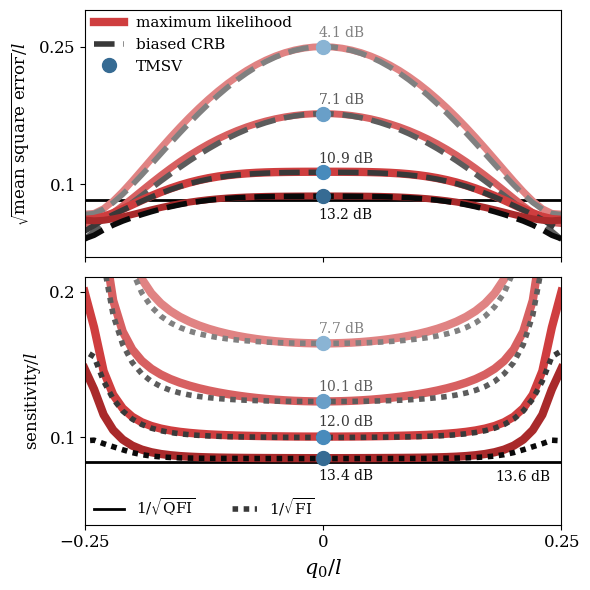

In [12]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4,10]

name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
sensor = sps.load_npz(path_data_states+name)
n = (n_op@sensor).diagonal().sum()
QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))

ax2.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')
ax1.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=None)

r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2
ax2.text(0.18,.07,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

print('QFI-r:',np.real(r_QFI),'dB-QFI:',dB_QFI, 'gain-QFI:',gain_QFI)
data_all = []
for T in T_range:
    
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_data_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    data_all.append(dictionary)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    shine = .5+.2*np.log(T)

    if T==4:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--')

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==4:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{FI}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))

    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    r = np.log(1/np.sqrt(MSE[int(steps/2)]))
    ind_mean = np.argmin((MSE[:int(steps/2)]-np.mean(MSE))**2)
    ind_max = int(steps/2)
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    rmin = np.log(1/np.sqrt(np.min(MSE)))
    print('squeezing parameter r:',rs, 'gain:',gains, 'dB:',10*np.log10(np.exp(2*rs)))
    print('squeezing parameter rmin:',rmin,'dB:',10*np.log10(np.exp(2*rmin)))

    x0, y0 = -.005, .01

    if T==10:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l-.025,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10,label='TMSV')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l-.015,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    else:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l+.007,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    print('average MSE',np.mean(MSE),np.mean(1/FIqT))


r_half = np.log(2)/2
r_10 = np.log(10)/2
r_20 = np.log(20)/2
r_40 = np.log(40)/2
print('as a reference for e^(-2r)=1/2, r is:',r_half,'gain:',np.cosh(r_half)**2, 'dB:',10*np.log10(np.exp(2*r_half)))
print('as a reference for e^(-2r)=1/10, r is:',r_10,'gain:',np.cosh(r_10)**2, 'dB:',10*np.log10(np.exp(2*r_10)))
print('as a reference for e^(-2r)=1/20, r is:',r_20,'gain:',np.cosh(r_20)**2, 'dB:',10*np.log10(np.exp(2*r_20)))
ax1.set_ylim(.02,.29)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.21)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [.1,.25]
y1labels = [r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)

name = 'Paper-Fig3-data'
with open(path_QS_figures_data+name+'.pkl', 'wb') as file:
    pickle.dump(data_all, file)

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
# plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

### p quadrature

sensor n 5.27312488122502
QFI-r: 1.5697539344554259 dB-QFI: 13.634709433598207 gain-QFI: 6.2839509072136925
1 0.0
squeezing parameter r: 0.8843271987854775 gain: 2.008380295764635 dB: 7.681168452589859
squeezing parameter rmin: 1.77975035395197 dB: 15.458715157733998
average MSE 0.21271620558622112 1.0306238438474467
2 0.0
squeezing parameter r: 1.1618102474890912 gain: 3.077625121383114 dB: 10.091355590063273
squeezing parameter rmin: 1.9464145534247796 dB: 16.90634200097128
average MSE 0.11519614336008195 0.15651277882876272
4 0.0
squeezing parameter r: 1.3774001234148445 gain: 4.445380653927061 dB: 11.9639454594385
squeezing parameter rmin: 1.8749524287100054 dB: 16.28562987239711
average MSE 0.06074052555691018 0.07716247599989562
10 0.0
squeezing parameter r: 1.5369540774279193 gain: 5.918124145229156 dB: 13.349813495312972
squeezing parameter rmin: 1.8941139333807142 dB: 16.452064587266154
average MSE 0.03862229404136359 0.048657190912719805
as a reference for e^(-2r)=1/2, r is: 

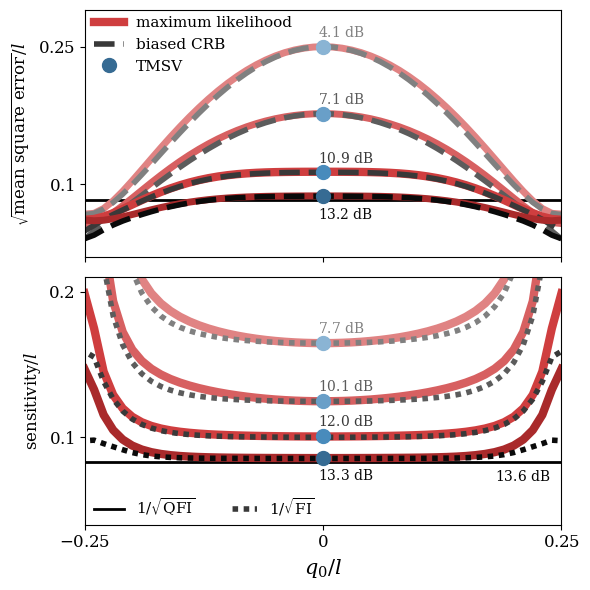

In [ ]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif'
})
Delta = .3
cd = np.cosh(Delta**2)
fig, axs = plt.subplots(2,1,figsize=(6,6),sharex=True)
ax1, ax2 = axs
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
T_range = [1,2,4,10]

name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
sensor = sps.load_npz(path_data_states+name)
n = (n_op@sensor).diagonal().sum()
QFI = np.real(1/(4*n+2))
print('sensor n',np.real(n))

ax2.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=r'1/$\sqrt{\text{QFI}}$')
ax1.plot([-1,1],[np.sqrt(QFI)/l,np.sqrt(QFI)/l],color=lighten_color('black',1),lw=2,ls='-',label=None)

r_QFI = np.log(1/np.sqrt(QFI))
dB_QFI = 10*np.log10(np.exp(2*r_QFI))
gain_QFI = np.cosh(r_QFI)**2
ax2.text(0.18,.07,r'${0:.1f}$ dB'.format(dB_QFI),fontsize=10,color=lighten_color('black',1))

print('QFI-r:',np.real(r_QFI),'dB-QFI:',dB_QFI, 'gain-QFI:',gain_QFI)
for T in T_range:
    
    name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_data_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']

    # ax1.plot(q0_range/l,MSE-biases**2,ls='-',color=lighten_color(red,.7),lw=2)
    # ax1.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=3,ls='--')
    shine = .5+.2*np.log(T)

    if T==4:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=6,label='maximum likelihood')
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--',label='biased CRB')
    else:
        ax1.plot(q0_range/l,np.sqrt(MSE)/l,ls='-',color=lighten_color(red,shine),lw=5)
        ax1.plot(q0_range/l, np.sqrt(partial_means**2/FIqT)/l,color=lighten_color('black',shine),lw=4,ls='--')

    # ax2.plot(q0_range/l, Var/partial_means**2,color=blue,lw=3)
    sensitivity = np.sqrt(MSE/partial_means**2)
    if T==4:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)),label=r'1/$\sqrt{\text{FI}}$')
    else:
        ax2.plot(q0_range/l, sensitivity/l,color=lighten_color(red,shine),lw=6)
        ax2.plot(q0_range/l, np.sqrt(1/FIqT)/l,color=lighten_color('black',shine),lw=4,ls=(1,(1,1)))
    print(T,q0_range[np.argmin(MSE/partial_means**2)]/l)


    r = np.log(1/np.sqrt(MSE[int(steps/2)]))
    ind_mean = np.argmin((MSE[:int(steps/2)]-np.mean(MSE))**2)
    ind_max = int(steps/2)
    dB = 10*np.log10(np.exp(2*r))
    gain = np.cosh(r)**2
    rs = np.log(1/np.min(sensitivity))
    gains = np.cosh(rs)**2
    dBs = 10*np.log10(np.exp(2*rs))
    rmin = np.log(1/np.sqrt(np.min(MSE)))
    print('squeezing parameter r:',rs, 'gain:',gains, 'dB:',10*np.log10(np.exp(2*rs)))
    print('squeezing parameter rmin:',rmin,'dB:',10*np.log10(np.exp(2*rmin)))

    x0, y0 = -.005, .01

    if T==10:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l-.025,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10,label='TMSV')
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l-.015,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    else:
        ax1.text(q0_range[ind_max]/l+x0,np.sqrt(MSE[ind_max])/l+.01,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',shine))
        ax1.plot(q0_range[ind_max]/l,np.sqrt(MSE[ind_max])/l,'o',color=lighten_color(blue,shine),markersize=10)
        ax2.text(q0_range[np.argmin(sensitivity)]/l+x0,sensitivity[np.argmin(sensitivity)]/l+.007,r'${0:.1f}$ dB'.format(dBs),fontsize=10,color=lighten_color('black',shine))
        ax2.plot(q0_range[np.argmin(sensitivity)]/l,sensitivity[np.argmin(sensitivity)]/l,'o',color=lighten_color(blue,shine),markersize=10)

    print('average MSE',np.mean(MSE),np.mean(1/FIqT))


r_half = np.log(2)/2
r_10 = np.log(10)/2
r_20 = np.log(20)/2
r_40 = np.log(40)/2
print('as a reference for e^(-2r)=1/2, r is:',r_half,'gain:',np.cosh(r_half)**2, 'dB:',10*np.log10(np.exp(2*r_half)))
print('as a reference for e^(-2r)=1/10, r is:',r_10,'gain:',np.cosh(r_10)**2, 'dB:',10*np.log10(np.exp(2*r_10)))
print('as a reference for e^(-2r)=1/20, r is:',r_20,'gain:',np.cosh(r_20)**2, 'dB:',10*np.log10(np.exp(2*r_20)))
ax1.set_ylim(.02,.29)
ax1.set_xlim(-.25,.25)
ax2.set_ylim(0.04,.21)
ax2.set_xlim(-.25,.25)
xticks = [-1/4,0,1/4]
xlabels = [r'$-0.25$',r'$0$',r'$0.25$']
ax2.set_xticks(xticks)
ax2.set_xticklabels(xlabels,fontsize=12)
ax2.set_xlabel(r'$q_0/l$',fontsize=15)
y1ticks = [.1,.25]
y1labels = [r'$0.1$',r'$0.25$']
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(y1labels,fontsize=12)
y2ticks = [.1,.2]
y2labels = [r'$0.1$',r'$0.2$']
ax2.set_yticks(y2ticks)
ax2.set_yticklabels(y2labels,fontsize=12)
ax1.set_ylabel(r'$\sqrt{\text{mean square error}}/l$',fontsize=12)
ax2.set_ylabel(r'$\text{sensitivity}/l$',fontsize=12)
ax1.legend(fontsize=11,loc='upper left',framealpha=0,bbox_to_anchor=(-0.01,1.03))
ax2.legend(fontsize=11,loc='lower left',framealpha=0,bbox_to_anchor=(-0.01,-0.03),ncol=2)

plt.tight_layout()
name = 'Paper-Fig3-ML-MSE-sensitivity'
# plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

### sensitivity as a function of $\Delta$ $T=10$

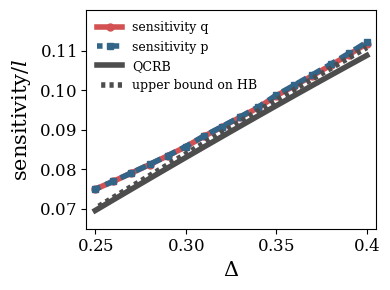

In [20]:
def minimal_sensitivity_delta(Delta, T):
    name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_data_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)

    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']
    sensitivity_q = np.sqrt(MSE/partial_means**2)

    name = 'data-noiseless-sensitivity-fullpmap-delta={0:.2f}-T={1:.0f}'.format(Delta,T)
    with open(path_data_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    
    MSE = dictionary['MSE']
    biases = dictionary['biases']
    partial_means = dictionary['partial_means']
    FIqT = dictionary['FIqT']
    sensitivity_p = np.sqrt(MSE/partial_means**2)
    
    return sensitivity_q , sensitivity_p

def CRB_HB_delta(Delta):
    name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
    sensor = sps.load_npz(path_data_states+name)
    n = np.real((n_op@sensor).diagonal().sum())
    CR = np.sqrt(1/(4*n+2))
    HB  = CR*np.sqrt(1+1/(8*n+4))
    return CR, HB

Delta_range = np.arange(.25,.41,.01)
T = 10
sensitivity_q_delta = []
sensitivity_p_delta = []
CR_delta, HB_delta = [], []
for Delta in Delta_range:
    sensitivity_q, sensitivity_p = minimal_sensitivity_delta(Delta, T)
    sensitivity_q_delta.append(sensitivity_q[len(sensitivity_q)//2])
    sensitivity_p_delta.append(sensitivity_p[len(sensitivity_p)//2])
    CRB, HB = CRB_HB_delta(Delta)
    CR_delta.append(CRB)
    HB_delta.append(HB)

fig, ax = plt.subplots(1,1,figsize=(4,3),sharex=True)
ax.plot(Delta_range, sensitivity_q_delta/l, color=lighten_color(red,.7), lw=4, label='sensitivity q',marker='o',markersize=5)
ax.plot(Delta_range, sensitivity_p_delta/l, color=blue, lw=4, label='sensitivity p',ls=(1,(2,1)),marker='s',markersize=5)
ax.plot(Delta_range, CR_delta/l, color=lighten_color('black',.7), lw=4, label='QCRB')
ax.plot(Delta_range, HB_delta/l, color=lighten_color('black',.7), lw=4, label='upper bound on HB',ls=(.75,(.75,.75)))
ax.set_xlabel(r'$\Delta$',fontsize=15)
ax.set_ylabel(r'$\text{sensitivity}/l$',fontsize=15)
ax.set_ylim(0.065,.1203)
ax.set_xlim(0.245,0.405)
y1labels = [r'$0.07$',r'$0.08$',r'$0.09$',r'$0.10$',r'$0.11$']
y1ticks = [.07,.08,.09,.1,.11]
xticks = [.25,.3,.35, .4]
xlabels = [r'$0.25$',r'$0.30$',r'$0.35$',r'$0.4$']
ax.set_yticks(y1ticks)
ax.set_yticklabels(y1labels,fontsize=12)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=12)
ax.legend(fontsize=9,loc='upper left',framealpha=0)

name =  'Paper-Fig-sensitivity-delta-bounds'
plt.tight_layout()
plt.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)
plt.show()

dict_figure = {}
dict_figure['sensitivity_q_delta'] = sensitivity_q_delta
dict_figure['sensitivity_p_delta'] = sensitivity_p_delta
dict_figure['CR_delta'] = CR_delta
dict_figure['HB_delta'] = HB_delta
dict_figure['Delta_range'] = Delta_range
name = 'data-sensitivity-delta-bounds'
with open(path_QS_figures_data+name+'.pkl', 'wb') as file:
    pickle.dump(dict_figure, file)

### sensitivity convergence

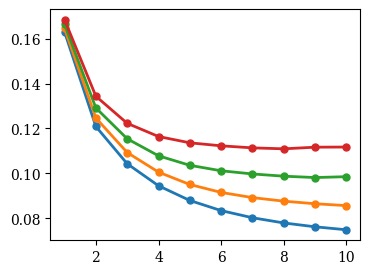

In [22]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

Delta_range =[.25,.3,.35,.4]
T_range = np.arange(1,11,1)
min_sensitivities = []
Holevo_bounds = []
steps = 101
for Delta in Delta_range:
    min_sensitivity = []
    for T in T_range:
        name = 'data-noiseless-sensitivity-fullqmap-delta={0:.2f}-T={1:.0f}-steps={2:.0f}'.format(Delta,T,steps)
        with open(path_data_results+name+'.pkl', 'rb') as file:
            dictionary = pickle.load(file)
        
        MSE = dictionary['MSE']
        biases = dictionary['biases']
        partial_means = dictionary['partial_means']
        FIqT = dictionary['FIqT']
        sensitivity = np.sqrt(MSE/partial_means**2)
        min_sensitivity.append(np.min(sensitivity))
    
    ax.plot(T_range,min_sensitivity/l,marker='o',label=r'$\Delta={0:.2f}$'.format(Delta),lw=2,markersize=5)
    min_sensitivities.append(min_sensitivity)

    name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,120)
    sensor = sps.load_npz(path_data_states+name)
    n = (n_op@sensor).diagonal().sum()
    HB = np.sqrt(1/(4*n+2))*np.sqrt(1+1/(8*n+4))
    Holevo_bounds.append(HB)
dict_figure = {}
dict_figure['min_sensitivities'] = min_sensitivities
dict_figure['T_range'] = T_range
dict_figure['Delta_range'] = Delta_range
dict_figure['Holevo_bounds'] = Holevo_bounds
name = 'data-noiseless-sensitivity-convergence.npz'
np.savez(path_QS_figures_data+name,**dict_figure)


# Running backaction evading 

## Constructing the estimators

### gaussian estimator (the l range ones are built in gaussian prior)

In [ ]:
k, steps, R = 0,51,10
Delta_range = [.25,.3,.35,.4]

for Delta in Delta_range:
    cd = np.cosh(Delta**2)
    q0_range = (l/4)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-lover4,lover4)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_results+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]

    T_range = np.arange(1,11,1)
    MSEs = []
    mse_qrange = []
    posteriors_all = []
    estimators_all = []
    for T in tqdm(T_range):
        mse_q, MSE, posteriors, estimators, probs_b = flat_MSE_qmap(probs_qp0_allbits,R,T,q0_range,steps)
        MSEs.append(MSE)
        mse_qrange.append(mse_q)
        posteriors_all.append(posteriors)
        estimators_all.append(estimators)

    MSEs = np.array(MSEs)
    mse_qrange = np.array(mse_qrange)
    posteriors_all = np.array(posteriors_all)
    estimators_all = np.array(estimators_all)
    dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators':estimators_all}
    name = 'flat_prior_fullqmap_Delta={0:.2f}_p0=lover{1:.0f}_q0range(-lover4,lover4)_steps={2:.0f}'.format(Delta,k,steps)
    with open(path_data_results+name+'.pkl', 'wb') as f:
        pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [01:23<00:00,  8.31s/it]
/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_67338/2385996022.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  posteriors_all = np.array(posteriors_all)
/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_67338/2385996022.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  estimators_all = np.array(estimators_all)
100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


## Backaction evading, testing return to the initial state

### Bayesian, saving data

In [ ]:
#work here now
Delta, R0 = .3, 120
R1, k, steps, l = 10, 0, 51, np.sqrt(2*np.pi)
cd = np.cosh(Delta**2)
gauges = [0,0]
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_states+name)
mean, sigma = 0,0.15
stddev_range = np.arange(0.05,l/4+.1,.01)
index_sigma = np.argmin(np.abs(stddev_range-0.15))

T_range = np.arange(10,11)
T_range = [2]
T_dict = {2:10,3:9,4:8,5:7,6:6,7:5,8:4,9:3,10:2}  # Mapping T to the corresponding M value
for T in T_range:
    if T % 2 == 0:
        name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
        sensor_gauge = sps.load_npz(path_data_states+name)
    else:
        name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
        sensor_gauge = sps.load_npz(path_data_states+name)
    steps2 = 101
    qrange = (l)*np.linspace(-1.0,1.0,steps2)
    exp_qrange_allqbits = []

    if k==0:
        p0 = 0
    else:
        p0 = l/k

    Tq, Tp = stabilizers(Delta)

    steps3 = 51
    q_test = (l/2)*np.linspace(0,1.0,steps3)
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_data_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    estimators_all = dictionary['estimators_all']
    estimators_allqbits_p0 = estimators_all[index_sigma]
    estimators_allpbits_q0 = estimators_all[index_sigma]

    M = T_dict[T]
    fidelities_yes = []
    fidelities_no = []
    fidelities_yes_simple = []
    fidelities_yes_filter = []
    for q0 in q_test:
        fidelities_yes_simple.append(backaction_evading_sBs_fidelities_probs_allqbits_simplerecovery(Delta,q0,p0,sensor,T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,sensor_gauge))
        fidelities_no.append(backaction_evading_sBs_fidelities_probs_allqbits_norecovery(Delta,q0,p0,sensor,T,M,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,sensor_gauge))
    fidelities_no = np.array(fidelities_no)
    fidelities_yes_simple = np.array(fidelities_yes_simple)
    name_yes_simple = 'fidelities_probs_allqbits_bayesian_BArecoverysimple=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    name_no = 'fidelities_probs_allqbits_bayesian_BArecovery=no_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    np.save(path_data_results+name_yes_simple,fidelities_yes_simple)
    np.save(path_data_results+name_no,fidelities_no)

/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/

### bayesian, dermining wheter the recovery is helpful or not

purity: [[1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 1.   +0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 0.999+0.j]
 [1.   +0.j 1.   +0.j 1.   +0.j 0.999+0.j]
 [0.999+0.j 1.   +0.j 1.   +0.j 0.999+0.j]
 [0.999+0.j 1.   +0.j 0.999+0.j 0.998+0.j]
 [0.999+0.j 0.999+0.j 0.999+0.j 0.997+0.j]
 [0.999+0.j 0.999+0.j 0.998+0.j 0.994+0.j]
 [0.998+0.j 0.998+0.j 0.995+0.j 0.989+0.j]
 [0.998+0.j 0.995+0.j 0.99 +0.j 0.979+0.j]
 [0.997+0.j 0.992+0.j 0.981+0.j 0.958+0.j]
 [0.996+0.j 0.984+0.j 0.963+0.j 0.92 +0.j]
 [0.995+0.j 0.972+0.j 0.931+0.j 0.852+0.j]
 [0.994+0.j 0.949+0.j 0.876+0.j 0.748+0.j]
 [0

(0.0, 0.3)

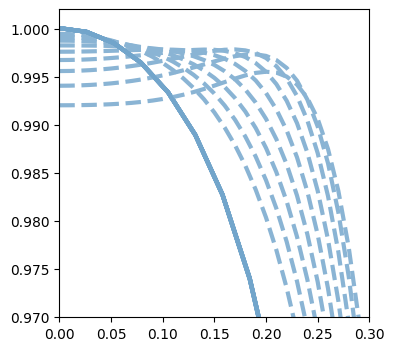

In [13]:
Delta, k, steps3 = 0.3, 0, 51
q_test = (l/2)*np.linspace(0,1.0,steps3)
q_test20 = (l/2)*np.linspace(0,1.0,20)

fig, ax = plt.subplots(1,1,figsize=(4,4))

T_range =  np.arange(2,11)
# M_range = np.arange(10,13,2)
M_range = [10]
T_dict = {2:10,3:9,4:8,5:7,6:6,7:5,8:4,9:3,10:2}  # Mapping T to the corresponding M value
sigma = 0.15*l
styles = ['-',(2,(2,1)),(1,(1,1)),(1,(1,2))]
colors = [light_blue,blue,green,red]
fidelities_yes_all = []
fidelities_yes_simple_all = []
fidelities_no_all = []
for j in range(len(T_range)):
    style = styles[j%len(styles)]
    T = T_range[j]
    # for i in range(len(M_range)):
        # M = M_range[i]
    M = T_dict[T]
    shine = .5 

    name_recovery_simple = 'fidelities_probs_allqbits_bayesian_BArecoverysimple=yes_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,steps3)
    name_norecovery = 'fidelities_probs_allqbits_bayesian_BArecovery=no_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_p0=lover{3:.0f}_q0range(0,lover2)_steps={4:.0f}'.format(Delta,T,M,k,20)
    fidelities_probs_yes_simple = np.load(path_data_results+name_recovery_simple+'.npy')
    fidelities_probs_no = np.load(path_data_results+name_norecovery+'.npy')

    fidelities_yes_simple = fidelities_probs_yes_simple[:,:,0]
    fidelities_no = fidelities_probs_no[:,:,0]
    probs_yes_simple = fidelities_probs_yes_simple[:,:,1]
    probs_no = fidelities_probs_no[:,:,1]

    if T==2:
        purity = fidelities_probs_yes_simple[:,:,2]
        print('purity:',np.round(purity,3))

    avg_fidelities_yes_simple = []
    avg_fidelities_no = []
    for index_q0 in range(20):
        avg_fidelities_no.append(np.dot(fidelities_no[index_q0],probs_no[index_q0]))
    for index_q0 in range(steps3):    
        avg_fidelities_yes_simple.append(np.dot(fidelities_yes_simple[index_q0],probs_yes_simple[index_q0]))
        
    avg_fidelities_yes_simple = np.real(np.array(avg_fidelities_yes_simple))
    avg_fidelities_no = np.real(np.array(avg_fidelities_no))
    
    ax.plot(q_test/l,avg_fidelities_yes_simple,color=lighten_color(blue,shine),lw=3, ls='--')
    ax.plot(q_test20/l,avg_fidelities_no,color=lighten_color(blue,.6),lw=3,ls='-')

    prior = np.exp(-q_test**2/(2*sigma**2))
    prior /= np.sum(prior)
    prior20 = np.exp(-q_test20**2/(2*sigma**2))
    prior20 /= np.sum(prior20)
    flat_prior = np.ones_like(prior)
    index_q0_lover4 = np.argmin(np.abs(q_test-l/4))
    flat_prior[index_q0_lover4:] = 0
    flat_prior /= np.sum(flat_prior)
    flat_prior20 = np.ones_like(prior20)
    flat_prior20 /= np.sum(flat_prior20)

    weighted_fidelities_yes_simple = avg_fidelities_yes_simple * prior
    weighted_fidelities_no = avg_fidelities_no * prior20
    flat_weighted_fidelities_no = avg_fidelities_no * flat_prior20
    print(T,'weighted fidelities yes simple:',np.sum(weighted_fidelities_yes_simple))
    print(T,'weighted fidelities no:',np.sum(weighted_fidelities_no))
    print(T,'flat weighted fidelities no:',np.sum(flat_weighted_fidelities_no))

    fidelities_yes_simple_all.append(avg_fidelities_yes_simple)
    fidelities_no_all.append(avg_fidelities_no)


dict_figure = {}
dict_figure['fidelities_yes_all'] = fidelities_yes_all
dict_figure['fidelities_yes_simple_all'] = fidelities_yes_simple_all
dict_figure['fidelities_no_all'] = fidelities_no_all    
dict_figure['q_test'] = q_test
print(len(fidelities_yes_all))
name = 'data-figure-fidelities-BA'
with open(path_QS_figures_data+name +'.pkl', 'wb') as f:
    pickle.dump(dict_figure, f, pickle.HIGHEST_PROTOCOL)

ax.set_ylim(.97,1.002)
ax.set_xlim(0,.3)
# ax.plot([0,.5],[.95,.95],color='black')
# ax.plot([.3,.3],[.5,1],color='black')

In [12]:
fidelities=np.array(fidelities)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(qrange/l,fidelities,color=blue,lw=3)

fidelity_995 = qrange[np.argmin(np.abs(fidelities-.995))]
print('0.995',fidelity_995/l)
fidelity_99 = qrange[np.argmin(np.abs(fidelities-.99))]
print('0.99',fidelity_99/l)
fidelity_95 = qrange[np.argmin(np.abs(fidelities-.95))]
print('0.95',fidelity_95/l)
fidelity_90 = qrange[np.argmin(np.abs(fidelities-.9))]
print('0.9',fidelity_90/l)

NameError: name 'fidelities' is not defined

## backaction evading parallel runs

### Sampling q0,p0 many repeats

In [ ]:
def running_BAEM_parallel(Delta,sigma,sensor,repeat_baem,T, M, estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits,runs):
    
    def single_run():
        # squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s, bitstrings  = backaction_evading_sBs_run_notrhos(Delta,sigma,sensor,repeat_baem, T, M ,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits)
        squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s, bitstrings  = backaction_evading_sBs_run_notrhos_simple(Delta,sigma,sensor,repeat_baem, T, M ,estimators_allqbits_p0,estimators_allpbits_q0,gauges,exp_qrange_allqbits)

        return np.array([squared_errors_q, squared_errors_p, estimators_q, estimators_p, q0s, p0s])

    result = Parallel(n_jobs=20)(delayed(single_run)() for _ in tqdm(range(runs)))
    return np.array(result)#shape [run][0=SEq,1=SEp,2=estq,3=estp][repeats]

Delta, R0 = .3, 120
R1, k, steps, l = 15, 0, 51, np.sqrt(2*np.pi)
gauges = [0,0]
T_range = [8]
M_range = [8]
T_dict = {2:10,3:9,4:8,5:7,6:6,7:5,8:4,9:3,10:2}  # Mapping T to the corresponding M value
name = 'sensor_Delta={0:.2f}_R={1:.0f}.npz'.format(Delta,R0)
sensor = sps.load_npz(path_data_states+name)
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = 0.15*l
sigma = stddev_range[np.argmin(np.abs(stddev_range-sigma))] # here change from 0.15 to 0.1
index_sigma = np.argmin(np.abs(stddev_range-sigma))
print('sigma:',sigma/l)

for T in T_range:
    steps2 = 101
    qrange = (l)*np.linspace(-1.0,1.0,steps2)
    name = 'expectation_value_q_allqbits_Bayesian_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps2)
    exp_qrange_allqbits = np.load(path_data_results+name+'.npy')

    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_data_results+name+'.pkl', 'rb') as file:
        dictionary = pickle.load(file)
    estimators_all = dictionary['estimators_all']
    estimators_allqbits_p0 = estimators_all[index_sigma]
    estimators_allpbits_q0 = estimators_all[index_sigma]

    runs_range = [4000]
    # M = T_dict[T]
    for M in M_range:
        for runs in runs_range:
            repeat_baem = 15
            result = running_BAEM_parallel(Delta,sigma,sensor,repeat_baem, T,M, estimators_allqbits_p0, estimators_allpbits_q0, gauges, exp_qrange_allqbits, runs)

            result = np.array(result)
            name = 'backaction_evading_simple_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
            np.save(path_data_results+name,result)

sigma: 0.15159806655254446


  0%|          | 20/4000 [00:00<00:31, 125.46it/s]/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/labl2714/.pyenv/versions/3.10.15/envs/LL_1/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve

## plotting

T: 4 M: 8
T: 4 M: 8 0.4445595327989763 0.4503039965011641
T: 4 0.4163842969259451
T: 8 M: 4
T: 8 M: 4 0.38245863518581685 0.3797712670280016
T: 8 0.34439905996394243


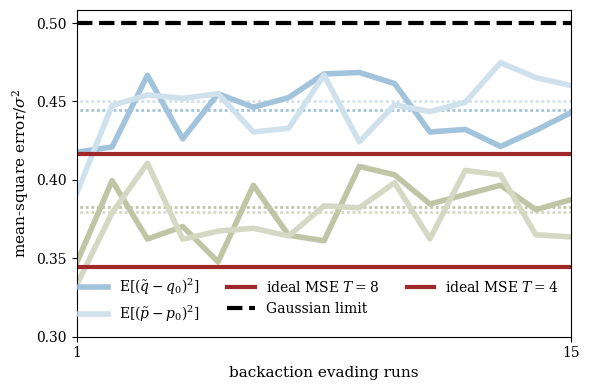

In [18]:
Delta = 0.3
k = 0
T_range = [4,8]
T_dict = {4:8, 6:6, 8:4, 10:2}
M_range = [4]
stddev_range = np.arange(0.05,l/4+.1,.01)
sigma = 0.15*l
sigma = stddev_range[np.argmin(np.abs(stddev_range-sigma))]
index_sigma = np.argmin(np.abs(stddev_range-sigma))
runs = 4000
repeat_baem = 15
steps = 51

fig, ax = plt.subplots(1,1,figsize=(6,4))
x_range = np.arange(1,repeat_baem+1,1)

colors = [blue, green, red]
mean_MSE_q_Trange = []
mean_MSE_p_Trange = []
mean_means_MSE_q_Trange = []
mean_means_MSE_p_Trange = []
ideal_MSE_Trange = []
for i in range(len(T_range)):
    T = T_range[i]
    M = T_dict[T]
    print('T:', T, 'M:', M)
    # for M in M_range:

    name = 'backaction_evading_simple_bayesian_Delta={0:.2f}_T={1:.0f}_M={2:.0f}_sigma={3:.2f}_runs={4:.0f}_repeats={5:.0f}'.format(Delta,T,M,sigma/l,runs,repeat_baem)
    result_simple = np.load(path_data_results+name+'.npy',allow_pickle=True)

    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_data_results+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    MSE = dictionary['MSEs']
    MSE_q = dictionary['mse_qrange']

    min_MSE = MSE[index_sigma]/stddev_range[index_sigma]**2 # not the min, just the value at the corresponding sigma
    ideal_MSE_Trange.append(min_MSE)

    squared_errors_q_simple = result_simple[:,0,:]
    squared_errors_p_simple = result_simple[:,1,:]
    mean_MSE_q_simple = np.mean(squared_errors_q_simple,axis=0)
    mean_MSE_p_simple = np.mean(squared_errors_p_simple,axis=0)
    mean_MSE_q_Trange.append(mean_MSE_q_simple)
    mean_MSE_p_Trange.append(mean_MSE_p_simple)

    mean_means_MSE_q_simple = np.mean(mean_MSE_q_simple[1:])/sigma**2
    mean_means_MSE_p_simple = np.mean(mean_MSE_p_simple[1:])/sigma**2
    stddev_means_MSE_q_simple = np.std(mean_MSE_q_simple[1:])/sigma**2
    stddev_means_MSE_p_simple = np.std(mean_MSE_p_simple[1:])/sigma**2
    mean_means_MSE_q_Trange.append(mean_means_MSE_q_simple)
    mean_means_MSE_p_Trange.append(mean_means_MSE_p_simple)

    print('T:', T, 'M:', M, mean_means_MSE_q_simple,mean_means_MSE_p_simple)
    print('T:', T, min_MSE)

    shine = .4+.2*i
    ax.plot(x_range,mean_means_MSE_q_simple*np.ones(len(x_range)),color=lighten_color(colors[i],shine),lw=2,label=None,ls=(1,(1,1)))
    ax.plot(x_range,mean_means_MSE_p_simple*np.ones(len(x_range)),color=lighten_color(colors[i],shine-.2),lw=2,label=None,ls=(1,(1,1)))
    
    
    if i ==0:
        ax.plot(x_range,mean_MSE_q_simple/sigma**2,color=lighten_color(colors[i],shine),lw=4,label=r'E$[(\tilde q-q_0)^2]$')
        ax.plot(x_range,mean_MSE_p_simple/sigma**2,color=lighten_color(colors[i],shine-.2),lw=4,label=r'E$[(\tilde p-p_0)^2]$')
        ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T=8$')
        ax.plot([1,31],[.5,.5],color='black',ls='--',lw=3,label=r'Gaussian limit')
    else:
        ax.plot(x_range,mean_MSE_q_simple/sigma**2,color=lighten_color(colors[i],shine),lw=4,label=None)
        ax.plot(x_range,mean_MSE_p_simple/sigma**2,color=lighten_color(colors[i],shine-.2),lw=4,label=None)
        ax.plot(x_range,min_MSE*np.ones(len(x_range)),color=lighten_color(red,1),lw=3,label=r'ideal MSE $T=4$')

ax.set_xticks([1,15])
ax.set_yticks([.3,.35,.4,.45,.5])
ax.set_xlabel(r'backaction evading runs',fontsize=11)
ax.set_ylabel(r'mean-square error$/\sigma^2$',fontsize=11)

dict_figure = {}
dict_figure['mean_MSE_q_Trange'] = mean_MSE_q_Trange
dict_figure['mean_MSE_p_Trange'] = mean_MSE_p_Trange
dict_figure['mean_means_MSE_q_Trange'] = mean_means_MSE_q_Trange
dict_figure['mean_means_MSE_p_Trange'] = mean_means_MSE_p_Trange
dict_figure['T_range'] = T_range
dict_figure['T_dict'] = T_dict
dict_figure['ideal_MSE_Trange'] = ideal_MSE_Trange
name = 'data-figure5-BA-performance'
np.savez(path_QS_figures_data+name+'.npz', **dict_figure)

# ax.set_ylim(0.27,.52)
ax.set_xlim(1,15)
ax.legend(loc='lower right',fontsize=10,ncol=3,framealpha=0)
plt.tight_layout()
# name = 'backaction_evading_MSE'
# fig.savefig(path_figures+name+'.pdf',bbox_inches='tight',dpi=1000)

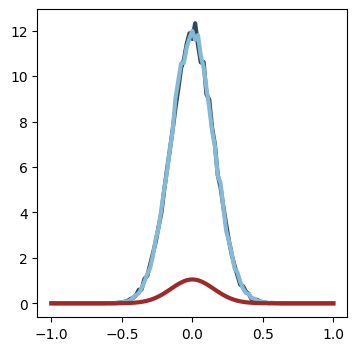

In [9]:
q0s = result_simple[:,4,:]
p0s = result_simple[:,5,:]

q_range = np.linspace(-l,l,101)
p_range = np.linspace(-l,l,101)

step = (q_range[1]-q_range[0])/2

counts_q0 = []
counts_p0 = []
for q0 in q_range:
    counts_q0.append(np.count_nonzero(np.abs(q0s-q0)<step))
    counts_p0.append(np.count_nonzero(np.abs(p0s-q0)<step))

counts_q0 = np.array(counts_q0)
counts_p0 = np.array(counts_p0)

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(q_range/l,counts_q0/runs*15,color=dark_blue,lw=3,label=r'$q_0$')
ax.plot(p_range/l,counts_p0/runs*15,color=light_blue,lw=3,label=r'$p_0$')
ax.plot(q_range/l,np.exp(-q_range**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),color=red,lw=3,label=r'Gaussian')

# Gaussian prior

## Saving the data full map

In [ ]:
Delta = 0.3
k, steps, R = 0,101,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
name = 'probs_allbits_p0=lover{0:.0f}_qrange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
probs_qp0_allbits = np.load(path_data_results+name+'.npy',allow_pickle=True)
probs_qp0_allbits = probs_qp0_allbits[:,0,:]
T_range = [1,2,4]
stddev_range = np.arange(0.05,l/4+.1,.01)
for T in T_range:
    MSEs = []
    mse_qrange = []
    posteriors_all = []
    for stddev in tqdm(stddev_range):
        mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
        MSEs.append(MSE)
        mse_qrange.append(mse_q)
        posteriors_all.append(posteriors)
    MSEs = np.array(MSEs)
    mse_qrange = np.array(mse_qrange)
    posteriors_all = np.array(posteriors_all)
    dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all}
    name = 'gaussian_prior_fullmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_data_results+name+'.pkl', 'wb') as f:
        pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)

T = 4
stddev = l/4
mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
print(MSE/stddev**2)
print('posterior',np.sum(posteriors[2]))
fig, axs = plt.subplots(1,3,figsize=(12,4))
ax1, ax2, ax3 = axs
ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/labl2714/Projects/GKP-metrology/GKP-metrology/sBs-noiseless//sBs/probabilities/probs_allbits_p0=lover0_qrange(-l,l)_steps=101_Delta=0.30_T=8.npy'

## saving the data qmap

In [ ]:
def saving_gaussian_prior_fullqmap(Delta):
    k, steps, R = 0,51,10
    cd = np.cosh(Delta**2)
    q0_range = (l)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_results+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]
    T_range = np.arange(1,11,1)
    stddev_range = np.arange(0.05,l/4+.1,.01)
    for T in tqdm(T_range):
        MSEs = []
        mse_qrange = []
        posteriors_all = []
        estimators_all = []
        for stddev in stddev_range:
            mse_q, MSE, posteriors, estimators, probs_b = gaussian_MSE_qmap(stddev,probs_qp0_allbits,R,T,q0_range,steps)
            MSEs.append(MSE)
            mse_qrange.append(mse_q)
            posteriors_all.append(posteriors)
            estimators_all.append(estimators)
        MSEs = np.array(MSEs)
        mse_qrange = np.array(mse_qrange)
        posteriors_all = np.array(posteriors_all)
        estimators_all = np.array(estimators_all)
        dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators_all':estimators_all}
        name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        with open(path_data_results+name+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)
    return None

Delta_range = np.arange(.25,.41,.01)
Parallel(n_jobs=-1)(delayed(saving_gaussian_prior_fullqmap)(Delta) for Delta in Delta_range)

# stddev = l/4
# mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
# print(MSE/stddev**2)
# print('posterior',np.sum(posteriors[2]))
# fig, axs = plt.subplots(1,3,figsize=(12,4))
# ax1, ax2, ax3 = axs
# ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
# ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
# ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

 90%|█████████ | 9/10 [46:42<11:15, 675.75s/it]

In [ ]:
def saving_gaussian_prior_fullpmap(Delta):
    k, steps, R = 0,51,10
    cd = np.cosh(Delta**2)
    q0_range = (l)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allpbits_q0=lover{0:.0f}_prange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_results+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]
    T_range = np.arange(1,11,1)
    stddev_range = np.arange(0.05,l/4+.1,.01)
    for T in tqdm(T_range):
        MSEs = []
        mse_qrange = []
        posteriors_all = []
        estimators_all = []
        for stddev in stddev_range:
            mse_q, MSE, posteriors, estimators, probs_b = gaussian_MSE_qmap(stddev,probs_qp0_allbits,R,T,q0_range,steps)
            MSEs.append(MSE)
            mse_qrange.append(mse_q)
            posteriors_all.append(posteriors)
            estimators_all.append(estimators)
        MSEs = np.array(MSEs)
        mse_qrange = np.array(mse_qrange)
        posteriors_all = np.array(posteriors_all)
        estimators_all = np.array(estimators_all)
        dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators_all':estimators_all}
        name = 'gaussian_prior_fullpmap_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        print(name)
        with open(path_data_results+name+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)

Delta_range = [.25,.3,.35,.4]
Parallel(n_jobs=-1)(delayed(saving_gaussian_prior_fullpmap)(Delta) for Delta in Delta_range)

# T = 4
# stddev = l/4
# mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
# print(MSE/stddev**2)
# print('posterior',np.sum(posteriors[2]))
# fig, axs = plt.subplots(1,3,figsize=(12,4))
# ax1, ax2, ax3 = axs
# ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
# ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
# ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

  0%|          | 0/10 [00:00<?, ?it/s]

gaussian_prior_fullpmap_Delta=0.35_T=1_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.40_T=1_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.25_T=1_q0=lover0_p0range(-l,l)_steps=51


 10%|█         | 1/10 [00:07<01:03,  7.04s/it]

gaussian_prior_fullpmap_Delta=0.30_T=1_q0=lover0_p0range(-l,l)_steps=51


 10%|█         | 1/10 [00:07<01:04,  7.12s/it]

gaussian_prior_fullpmap_Delta=0.40_T=2_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.35_T=2_q0=lover0_p0range(-l,l)_steps=51


 20%|██        | 2/10 [00:20<01:26, 10.86s/it]

gaussian_prior_fullpmap_Delta=0.25_T=2_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.30_T=2_q0=lover0_p0range(-l,l)_steps=51


 20%|██        | 2/10 [00:21<01:30, 11.28s/it]

gaussian_prior_fullpmap_Delta=0.35_T=3_q0=lover0_p0range(-l,l)_steps=51
gaussian_prior_fullpmap_Delta=0.40_T=3_q0=lover0_p0range(-l,l)_steps=51


 30%|███       | 3/10 [00:47<02:06, 18.10s/it]

gaussian_prior_fullpmap_Delta=0.25_T=3_q0=lover0_p0range(-l,l)_steps=51


 30%|███       | 3/10 [00:48<02:08, 18.41s/it]

gaussian_prior_fullpmap_Delta=0.30_T=3_q0=lover0_p0range(-l,l)_steps=51


 30%|███       | 3/10 [00:48<02:10, 18.63s/it]

## numerically limit $\Delta\to 0$

In [41]:
def pg_q0(q0):
    return (1/2) * (1 + np.sin(l * q0))

def prob_ideal_bit(bit,q0):
    prob = 1
    for b in bit:
        if b == '0':
            prob *= pg_q0(q0)
        else:
            prob *= (1-pg_q0(q0))
    return prob

q0_range = np.linspace(-l,l,101)
probs_ideal_bit = []
r = 4
for i in range(2**r):
    bit = int_to_r_bits(i,r)
    probs = prob_ideal_bit(bit,q0_range)
    probs_ideal_bit.append(probs)
probs_ideal_bit = np.array(probs_ideal_bit)

print(np.sum(probs_ideal_bit,axis=0))


def MSE_onlyqorp(p_array: list, vlist: list, variance: float = 1, r: int = 1):

    def p_gaussian_prior(v: list, variance: float = 1):
        p_v = (1.0 / (np.sqrt(2 * np.pi) * variance)) * np.exp(
            -(1 / (2 * variance)) * v ** 2
        )
        return p_v / sum(p_v)

    p_array = np.transpose(p_array)
    estimator_arr = np.empty((2 ** (r)))
    posterior_arr = np.empty((2 ** (r), len(vlist)))

    for idx in range(2 ** (r)):
        p_y = sum(p_array[:, idx] * p_gaussian_prior(vlist, variance))  #gaussian prior
        posterior = p_array[:, idx] * p_gaussian_prior(vlist, variance) / p_y #gaussian posterior
        posterior_arr[idx, :] = posterior
        estimator_arr[idx] = sum(vlist * posterior)

    MSD_v_ = np.sum(
        p_array
        * (
            np.ones((len(vlist), 2 ** (r))) * estimator_arr
            - (vlist * np.ones((2 ** (r), len(vlist)))).T
        )
        ** 2,
        axis=1,
    )
    MSD = np.sum(p_gaussian_prior(vlist, variance) * np.array(MSD_v_))
    return MSD
    
stddev_range = np.arange(0.05,l/4+.1,.01)
variance = (0.15*l)**2
MSE_ideal = MSE_onlyqorp(probs_ideal_bit, q0_range, variance, r)
print(MSE_ideal/variance)

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

print(analytical_1(variance)/variance)
print(analytical_2(variance)/variance)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]
0.3468710668256406
0.6345954682858064
0.4836686452910889


## paper plot Fig 4

0.5 0.5
min ratio 0.41585374115828005
max 2.206483736859944 19.16527422655081 variance 0.0025000000000000005
index min 32 T 4
min 1.771956841931875 15.391021572434518
stddev1 0.19548171739670206 stddev2 0.10372499290437254
squeezing parameter r: 1.1641611633476707 gain: 3.089543018868183 dB: 10.111775385759271
min ratio 0.5301928739610037
max 2.170804143969217 18.855365220370864 variance 0.0025000000000000005
index min 33 T 2
min 1.771956841931875 15.391021572434518
min ratio 0.6583165331336829
max 2.141665112148214 18.602266805813564 variance 0.0025000000000000005
index min 35 T 1
min 1.771956841931875 15.391021572434518


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_87989/4032961597.py:159: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)


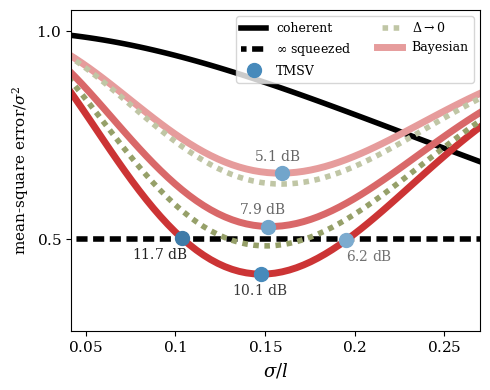

In [16]:
def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

Delta, k, steps, R = 0.3,0,51,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.arange(0.05,l/4+.1,.01)

print(coherent_limit(1),gaussian_limit(1))

fig, ax = plt.subplots(1,1,figsize=(5,4))

line1, = ax.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
lines = [line1,line2]

data_all = []
T_range = [4,2,1]
for i in range(3):
    T = T_range[i]
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    name2 = 'gaussian_prior_fullpmap_Delta={0:.2f}_T={1:.0f}_q0=lover{2:.0f}_p0range(-l,l)_steps={3:.0f}'.format(Delta,T,4,steps)
    with open(path_data_results+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    data_all.append(dictionary)
    MSE = dictionary['MSEs']
    MSE_q = dictionary['mse_qrange']

    with open(path_data_results+name2+'.pkl', 'rb') as f:
        dictionary2 = pickle.load(f)
    MSE2 = dictionary2['MSEs']
    MSE_p = dictionary2['mse_qrange']

    shine = .4+.3*np.log(T)
    if i==2:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5,label='Bayesian')
        # ax.plot(stddev_range,MSE2/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--')
    else:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5)
        # ax.plot(stddev_range,MSE2/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='--')

    print('min ratio',np.min(MSE/stddev_range**2))

    variance_list = stddev_range**2
    r_array = minimum_r(variance_list,MSE)
    r_max, argmax = np.max(r_array), np.argmax(r_array)
    print('max',r_max, 10*np.log10(np.exp(2*r_max)), 'variance',variance_list[argmax])

    ind = np.argmin(np.abs(MSE)/variance_list)
    index_gaussian = np.argmin(np.abs(MSE[ind:]/variance_list[ind:] - 0.5))
    print('index min',ind,'T',T)

    ind_min = 12
    r_min = solve_for_r(variance_list[ind_min], variance_list[ind_min]/2)
    db_min = 10*np.log10(np.exp(2*r_min))
    print('min',r_min, db_min)
    
    if i==0:
        index_gaussian = np.argmin(np.abs(MSE[ind:]/variance_list[ind:] - 0.5))
        index_gaussian2 = np.argmin(np.abs(MSE[:ind]/variance_list[:ind] - 0.5))
        print('stddev1',stddev_range[ind+index_gaussian]/l,'stddev2',stddev_range[index_gaussian2]/l) 
    else:
        pass

    if i==0:
        r = solve_for_r(variance_list[ind], MSE[ind])
        dB = 10*np.log10(np.exp(2*r))
        gain = np.cosh(r)**2
        rg1 = solve_for_r(variance_list[ind+index_gaussian], MSE[ind+index_gaussian])
        dbg1 = 10*np.log10(np.exp(2*rg1))
        rg2 = solve_for_r(variance_list[index_gaussian2], MSE[index_gaussian2])
        dbg2 = 10*np.log10(np.exp(2*rg2))
        rmin = solve_for_r(variance_list[ind_min], MSE[ind_min])
        dBmin = 10*np.log10(np.exp(2*rmin))
        print('squeezing parameter r:',r, 'gain:',gain, 'dB:',dB)
        ax.text(np.sqrt(variance_list[ind])-.04,MSE[ind]/variance_list[ind]-.05,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',.2+r/2))
        line4, = ax.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,.2+r/2),markersize=10,label='TMSV')
        lines.append(line4)
        ax.text(np.sqrt(variance_list[ind+index_gaussian])+.0,MSE[ind+index_gaussian]/variance_list[ind+index_gaussian]-.05,r'${0:.1f}$ dB'.format(dbg1),fontsize=10,color=lighten_color('black',.2+rg1/2))
        ax.plot(np.sqrt(variance_list[ind+index_gaussian]),MSE[ind+index_gaussian]/variance_list[ind+index_gaussian],'o',color=lighten_color(blue,.2+rg1/2),markersize=10,label=None)
        ax.text(np.sqrt(variance_list[index_gaussian2])-.07,MSE[index_gaussian2]/variance_list[index_gaussian2]-.05,r'${0:.1f}$ dB'.format(dbg2),fontsize=10,color=lighten_color('black',.2+rg2/2))
        ax.plot(np.sqrt(variance_list[index_gaussian2]),MSE[index_gaussian2]/variance_list[index_gaussian2],'o',color=lighten_color(blue,.2+rg2/2),markersize=10,label=None)
        # ax.text(np.sqrt(variance_list[ind_min])-.06,MSE[ind_min]/variance_list[ind_min]-.04,r'${0:.1f}$ dB'.format(dBmin),fontsize=13,color=lighten_color('black',1))
        # ax.plot(np.sqrt(variance_list[ind_min]),MSE[ind_min]/variance_list[ind_min],'o',color=lighten_color('black',1),markersize=10,label=None)
    elif i==1 or i==2:
        r = solve_for_r(variance_list[ind], MSE[ind])
        dB = 10*np.log10(np.exp(2*r))
        gain = np.cosh(r)**2
        rg2 = solve_for_r(variance_list[index_gaussian2], MSE[index_gaussian2])
        dbg2 = 10*np.log10(np.exp(2*rg2))
        rmin = solve_for_r(variance_list[ind_min], MSE[ind_min])
        dBmin = 10*np.log10(np.exp(2*rmin))
        ax.text(np.sqrt(variance_list[ind])-.04,MSE[ind]/variance_list[ind]+.03,r'${0:.1f}$ dB'.format(dB),fontsize=10,color=lighten_color('black',1-.4))
        ax.plot(np.sqrt(variance_list[ind]),MSE[ind]/variance_list[ind],'o',color=lighten_color(blue,1-.4),markersize=10)
        # ax.text(np.sqrt(variance_list[index_gaussian2])+0.01,MSE[index_gaussian2]/variance_list[index_gaussian2]-.01,r'${0:.1f}$ dB'.format(dbg2),fontsize=13,color=lighten_color('black',1-.2))
        # ax.plot(np.sqrt(variance_list[index_gaussian2]),MSE[index_gaussian2]/variance_list[index_gaussian2],'o',color=lighten_color('black',1-.2),markersize=10,label=None)
        # ax.text(np.sqrt(variance_list[ind_min])-.0,MSE[ind_min]/variance_list[ind_min]+.015,r'${0:.1f}$ dB'.format(dBmin),fontsize=13,color=lighten_color('black',1))
        # ax.plot(np.sqrt(variance_list[ind_min]),MSE[ind_min]/variance_list[ind_min],'o',color=lighten_color('black',1),markersize=10,label=None)
    if i==2:
        line5, = ax.plot(stddev_range,analytical_1(variance_list)/variance_list,color=lighten_color(green,.6),ls=(1,(1,1)),lw=4,label=r'$\Delta\to 0$')
        lines.append(line5)
    elif i==1:
        ax.plot(stddev_range,analytical_2(variance_list)/variance_list,color=lighten_color(green,1),ls=(1,(1,1)),lw=4)
    lines.append(line3)


handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(.28,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{mean-square error}/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

name = 'Paper-Fig4-data'
with open(path_QS_figures_data+name+'.pkl', 'wb') as f:
    pickle.dump(data_all, f, pickle.HIGHEST_PROTOCOL)

plt.tight_layout()
# name = 'noiseless-gaussian-delta={0:.2f}'.format(Delta)
# plt.savefig(path_figures+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
# plt.show()

## Variance of MSE

### computing it

In [3]:
k, steps, R = 0,51,10
Delta_range = [0.3]
T_range = [1,2,4,8]


for Delta in Delta_range:

    cd = np.cosh(Delta**2)
    q0_range = (l)*np.linspace(-1.0,1.0,steps)
    name = 'probs_allqbits_p0=lover{0:.0f}_qrange(-l,l)_steps={1:.0f}_Delta={2:.2f}_T={3:.0f}'.format(k,steps,Delta,R)#D\equiv /, division
    probs_qp0_allbits = np.load(path_data_results+name+'.npy',allow_pickle=True)
    # probs_qp0_allbits = probs_qp0_allbits[:,0,:]
    stddev_range = np.arange(0.05,l/4+.1,.01)
    for T in T_range:
        MSEs = []
        mse_qrange = []
        posteriors_all = []
        estimators_all = []
        for stddev in tqdm(stddev_range):
            mse_q, MSE, posteriors, estimators, probs_b = gaussian_MSE_qmap(stddev,probs_qp0_allbits,R,T,q0_range,steps)
            MSEs.append(MSE)
            mse_qrange.append(mse_q)
            posteriors_all.append(posteriors)
            estimators_all.append(estimators)
        MSEs = np.array(MSEs)
        mse_qrange = np.array(mse_qrange)
        posteriors_all = np.array(posteriors_all)
        estimators_all = np.array(estimators_all)
        dictionary = {'MSEs':MSEs,'mse_qrange':mse_qrange,'posteriors_all':posteriors_all,'estimators_all':estimators_all}
        name = 'MSEsquared_gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        with open(path_data_results+name+'.pkl', 'wb') as f:
            pickle.dump(dictionary, f, pickle.HIGHEST_PROTOCOL)
T = 4
stddev = l/4
mse_q, MSE, posteriors, probs_b = gaussian_MSE(stddev,probs_qp0_allbits,R,T,q0_range,steps)
# print(MSE/stddev**2)
# print('posterior',np.sum(posteriors[2]))
# fig, axs = plt.subplots(1,3,figsize=(12,4))
# ax1, ax2, ax3 = axs
# ax1.plot(q0_range/l,np.sqrt(mse_q)/l,color=red,label='sequential',lw=6)
# ax2.plot(q0_range/l,posteriors[0]/l,color=red,label='sequential',lw=6)
# ax3.plot(stddev_range/l,MSEs/stddev_range**2,color=red,label='sequential',lw=6)

 15%|█▍        | 10/68 [00:01<00:10,  5.69it/s]


KeyboardInterrupt: 

### plotting

0.5 0.5


/var/folders/vk/yq14ng8x7rd4q_4cz8t84tj80000gq/T/ipykernel_91810/3344942041.py:105: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)


[0.30810853 0.30861701 0.30915347 0.30971858 0.3103126  0.31093639
 0.31159021 0.31227494 0.31299124 0.31373969 0.31452058 0.31533434
 0.31618107 0.31706128 0.3179755  0.31892377]


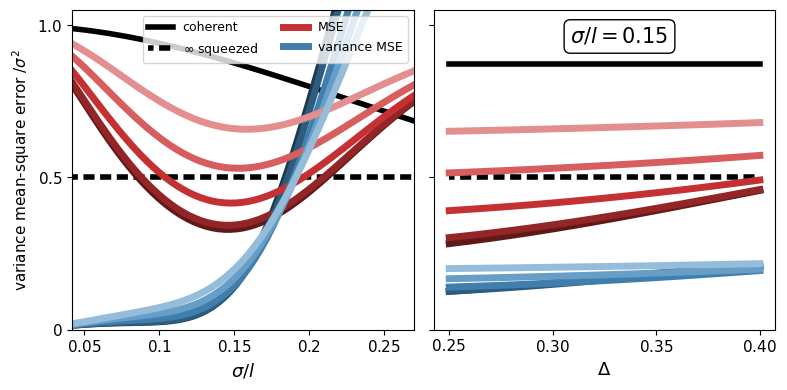

In [10]:
def coherent_limit(v):
    return 1/(v+1)
def gaussian_limit(v):
    return v/2/v

def two_mode_squeezing_limit(v,r):
    return np.exp(-2*r)*v/(np.exp(-2*r)+v)
from scipy.optimize import fsolve
def solve_for_r(v, MSE):
    # Define the equation to solve
    def equation(r):
        return two_mode_squeezing_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def solve_for_r_coherent(v,MSE):
    # Define the equation to solve
    def equation(r):
        return coherent_limit(v, r) - MSE
    # Use fsolve to find the root of the equation
    r_initial_guess = 0.5 # Initial guess for r
    r_solution = fsolve(equation, r_initial_guess)
    return r_solution[0]

def minimum_r(stddev_range,MSE_array):
    r_array = np.zeros(len(MSE_array))
    for i in range(len(MSE_array)):
        MSE = MSE_array[i]
        v = stddev_range[i]
        r = solve_for_r(v, MSE)
        r_array[i] = r
    return r_array

def analytical_1(v):
    return v*(1-l**2*v*np.exp(-l**2*v))
def analytical_2(v):
    a = l**2*v
    return v*(1-2*a/(np.cosh(a)+2*np.sinh(a)))

Delta, k, steps, R = 0.3,0,51,4
cd = np.cosh(Delta**2)
q0_range = (l)*np.linspace(-1.0,1.0,steps)
stddev_range = np.arange(0.05,l/4+.1,.01)

print(coherent_limit(1),gaussian_limit(1))

fig, axs = plt.subplots(1,2,figsize=(8,4), sharey=True)
ax, ax2 = axs

line1, = ax.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
line2, = ax.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
# ax2.plot(stddev_range, coherent_limit(stddev_range**2),color='black',ls='-',lw=4,label='coherent')
# ax2.plot(stddev_range, gaussian_limit(stddev_range**2),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
lines = [line1,line2]

T_range = [10,8,4,2,1]
MSE_all = []
MSE2_all = []
mse_delta_all = []
variance_delta_all = []

for i in range(5):
    T = T_range[i]
    # print('T',T,i)
    name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    name2 = 'gaussian2_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
    with open(path_data_results+name+'.pkl', 'rb') as f:
        dictionary = pickle.load(f)
    MSE = dictionary['MSEs']
    MSE_all.append(MSE)
    MSE_q = dictionary['mse_qrange']

    with open(path_data_results+name2+'.pkl', 'rb') as f:
        dictionary2 = pickle.load(f)
    MSE2 = dictionary2['MSEs']#variance 
    MSE2_all.append(MSE2)
    MSE_p = dictionary2['mse_qrange']

    shine = 1.25-.2*i
    if i==2:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5,label='MSE')
        line4, = ax.plot(stddev_range,(MSE2-MSE**2)/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='-', label='variance MSE')
    else:
        line3, = ax.plot(stddev_range,MSE/stddev_range**2,color=lighten_color(red,shine),lw=5)
        line4, = ax.plot(stddev_range,(MSE2-MSE**2)/stddev_range**2,color=lighten_color(blue,shine),lw=5,ls='-')
    lines.append(line3)
    lines.append(line4)

handles = lines
labels = [h.get_label() for h in handles]

l = np.sqrt(2*np.pi)
ax.set_xlim(0.042*l,0.27*l)
ax.set_ylim(.0,1.05)
ax.set_xlabel(r'$\sigma/l$',fontsize=13)
ax.set_xticks([0.05*l,0.1*l,0.15*l,0.2*l,0.25*l])
ax.set_yticks([0,0.5,1])
xlabels = [r'$0.05$',r'$0.1$',r'$0.15$',r'$0.2$',r'$0.25$']
ylabels = [r'0',r'$0.5$',r'$1.0$']
ax.set_xticklabels(xlabels,fontsize=11)
ax.set_yticklabels(ylabels,fontsize=11)
ax.set_ylabel(r'$\text{variance mean-square error }/\sigma^2$',fontsize=11)
ax.legend(handles, labels,loc='upper right',fontsize=9,frameon=True,ncol=2)

Delta_range = np.arange(.25,.41,.01)
index = np.argmin(np.abs(stddev_range-0.15*l))
ax2.plot(Delta_range, coherent_limit(stddev_range**2)[index]*np.ones(len(Delta_range)),color='black',ls='-',lw=4,label='coherent')
ax2.plot(Delta_range, gaussian_limit(stddev_range**2)[index]*np.ones(len(Delta_range)),color='black',ls=(1,(2,1)),lw=4,label=r'$\infty$ squeezed')
lines = []
for i in range(5):
    T = T_range[i]
    shine = 1.25-.2*i
    variance_delta = []
    mse_delta = []
    for j in range(len(Delta_range)):
        Delta = Delta_range[j]
        name = 'gaussian_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        name2 = 'gaussian2_prior_fullqmap_Delta={0:.2f}_T={1:.0f}_p0=lover{2:.0f}_q0range(-l,l)_steps={3:.0f}'.format(Delta,T,k,steps)
        with open(path_data_results+name+'.pkl', 'rb') as f:
            dictionary = pickle.load(f)
        MSE = dictionary['MSEs']
        MSE_q = dictionary['mse_qrange']

        # index = np.argmin(MSE/stddev_range**2)
        with open(path_data_results+name2+'.pkl', 'rb') as f:
            dictionary2 = pickle.load(f)
        MSE2 = dictionary2['MSEs']#variance 
        MSE_p = dictionary2['mse_qrange']

        variance_delta.append((MSE2[index]-MSE[index]**2)/stddev_range[index]**2)
        mse_delta.append(MSE[index]/stddev_range[index]**2)
        # print(MSE2[index],MSE[index],stddev_range[index]/l)
    mse_delta_all.append(mse_delta)
    variance_delta_all.append(variance_delta)
    if i==0:
        line2, = ax2.plot(Delta_range,mse_delta,color=lighten_color(red,shine),lw=5,label=r'$\Delta = {0:.2f}$'.format(Delta))
        line1, = ax2.plot(Delta_range,variance_delta,color=lighten_color(blue,shine),lw=5,label=r'$\Delta = {0:.2f}$'.format(Delta))
    else:
        ax2.plot(Delta_range,mse_delta,color=lighten_color(red,shine),lw=5,ls='-', label='variance MSE')
        ax2.plot(Delta_range,variance_delta,color=lighten_color(blue,shine),lw=5,ls='-', label='variance MSE')
    lines.append(line1)

print(np.array(variance_delta)/np.array(mse_delta))

ax2.set_xticks([0.25,0.3,0.35,0.4])
xlabels = [r'0.25',r'$0.30$',r'$0.35$',r'$0.40$']
ax2.set_xticklabels(xlabels,fontsize=11)

ax2.set_xlabel(r'$\Delta$',fontsize=13)

# Add textbox with sigma value
ax2.text(0.4, 0.95, r'$\sigma/l = 0.15$', transform=ax2.transAxes, fontsize=15,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
ax2.set_ylim(0,1.05)

plt.tight_layout()
name = 'noiseless-gaussian-mse-variance'
# plt.savefig(path_figures+name+'.pdf',format='pdf',bbox_inches='tight',dpi=1000)
plt.show()

dict_figure = {}
dict_figure['T_range'] = T_range
dict_figure['Delta_range'] = Delta_range
dict_figure['MSE_all'] = MSE_all
dict_figure['MSE2_all'] = MSE2_all
dict_figure['mse_delta_all'] = mse_delta_all
dict_figure['variance_delta_all'] = variance_delta_all
dict_figure['stddev_range'] = stddev_range
dict_figure['coherent_limit'] = coherent_limit(stddev_range**2)
dict_figure['gaussian_limit'] = gaussian_limit(stddev_range**2)
name = 'data-noiseless-gaussian-mse-variance'
np.savez(path_QS_figures_data+name+'.npz', **dict_figure)

# name = 'data-noiseless-gaussian-mse-variance'
# dict_figure = np.load(path_QS_figures_data+name+'.npz',allow_pickle=True)
# T_range = dict_figure['T_range']
# Delta_range = dict_figure['Delta_range']
# MSE_all = dict_figure['MSE_all']
# MSE2_all = dict_figure['MSE2_all']
# mse_delta_all = dict_figure['mse_delta_all']
# variance_delta_all = dict_figure['variance_delta_all']
# stddev_range = dict_figure['stddev_range']
# coherent_limit = dict_figure['coherent_limit']
# gaussian_limit = dict_figure['gaussian_limit']